In [501]:
import os
import numpy as np
import random
import torch
import time
import optuna
from pathlib import Path
from train_dqn import train_dqn
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [502]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [503]:
from envs.GraphEnv.impnode import ImpnodeEnv
import DQN_agent_modular

In [504]:
# variables for training the agent

num_train_eps = 10000 #10000 number training episodes to run
num_mem_fill_eps = 1000#1000 number of episodes to run to initialize the memory
discount = 0.99 # gamma used for computing return
batch_size = 64 # number of transitions to sample from replay buffer for each learn step
mem_capacity = 5000  # 500000 size of the memory buffer
update_frequency = 100 #1000 number of interactions after which the target buffer is updated
eps_max = 1.0 # initial epsilon value
eps_min = 0.05 # final epsilon value
eps_step = 1000 #1000 amount by which epsilon is decayed at each episode
lr = 0.0001 # learning rate for the network
alpha = 0.001 # weighing factor for graph reconstruction loss

gnn_depth=3
state_size=2
hidden_size1=16
hidden_size2=64
action_size=1
n_step=3

num_nodes = (30, 50)
anc = 'nd'
g_type = 'barabasi_albert'
val_data_path = 'data/synthetic/degree_cost/30-50'
val_data_path = Path.cwd()/val_data_path

model_name = 'model'


In [505]:
results_base_path_train = "results/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                           device, alpha, num_train_eps, num_mem_fill_eps, discount, batch_size, mem_capacity, update_frequency, eps_max, eps_min, eps_step, lr, gnn_depth, state_size, hidden_size1, hidden_size2, action_size, n_step, num_nodes, anc, g_type)

if not os.path.exists(results_base_path_train):
    os.makedirs(results_base_path_train)
else:
    timestamp = time.strftime("%Y%m%d%H%M%S")
    new_directory = f"{results_base_path_train}_{timestamp}"
    os.makedirs(new_directory)
    results_base_path_train = new_directory
    print(f"Directory already exists. Created a new one: {new_directory}")



Directory already exists. Created a new one: results/cuda_0.001_10000_1000_0.99_64_5000_100_1.0_0.05_1000_0.0001_3_2_16_64_1_3_(30, 50)_nd_barabasi_albert_20240408142240


In [506]:
env_train = ImpnodeEnv(anc=anc, 
                       g_type='barabasi_albert', 
                       num_nodes=num_nodes, 
                       mode='train'
                       )

In [507]:
# create the dqn_agent
dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                             alpha=alpha,
                                             gnn_depth=gnn_depth,
                                             state_size=state_size,
                                             hidden_size1=hidden_size1,
                                             hidden_size2=hidden_size2,
                                             action_size=action_size,
                                             discount=discount,
                                             eps_max=eps_max,
                                             eps_min=eps_min,
                                             eps_step=eps_step,
                                             memory_capacity=mem_capacity,
                                             lr=lr,
                                             mode='train')


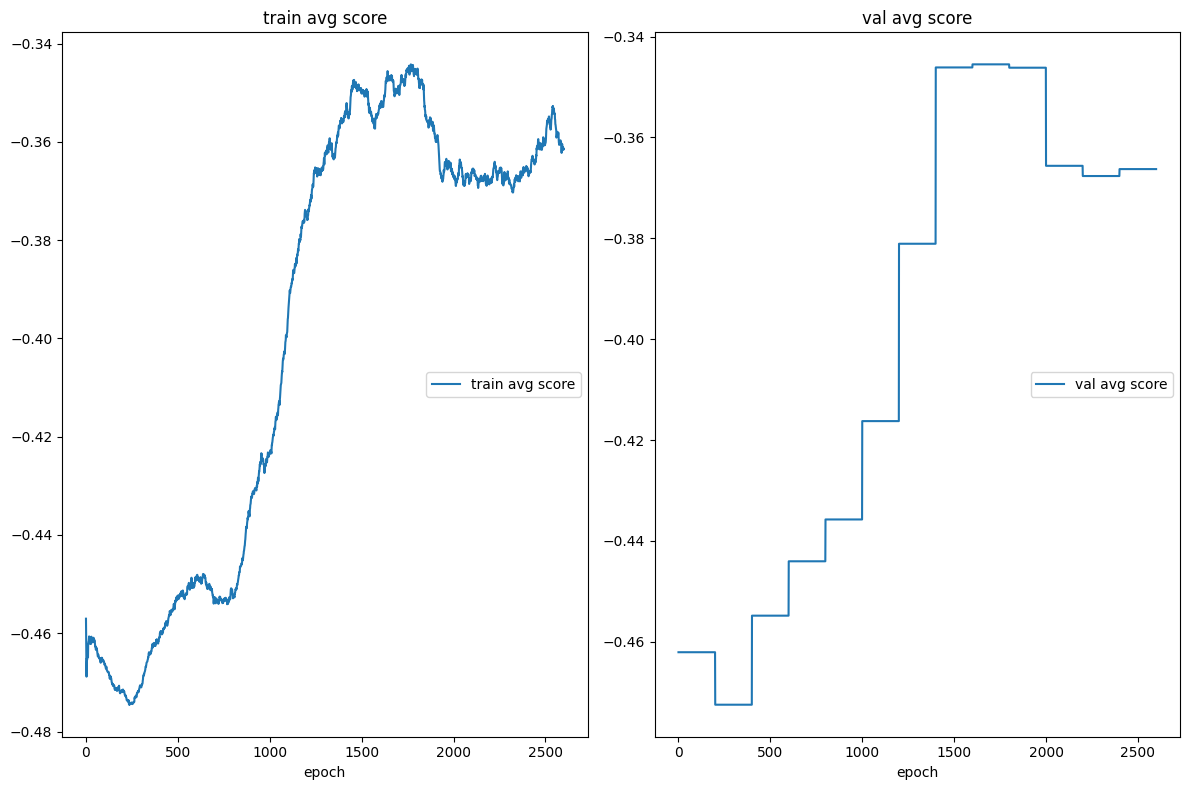

train avg score
	train avg score  	 (min:   -0.475, max:   -0.344, cur:   -0.362)
val avg score
	val avg score    	 (min:   -0.472, max:   -0.346, cur:   -0.366)
EarlyStopping counter: 5 out of 5
Early stopping


-0.3613316879532151

In [508]:
train_dqn(env_train, dqn_agent_train, results_base_path_train, num_train_eps, num_mem_fill_eps, n_step, batch_size, update_frequency, val_data_path, model_name)


In [509]:
print('done')

done


# visualize train and val performance

In [510]:
path='results/cuda_0.001_3000_500_0.99_64_1500_100_1.0_0.05_100_0.001_4_2_32_64_1_3_(30, 50)_4_dw_nd_None_None_20240404151903'
import pandas as pd
import matplotlib.pyplot as plt
out = pd.read_csv('{}/info.csv'.format(path))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_ylabel('episode')
ax1.set_xlabel('train avg score')
ax2.set_xlabel('val avg score')
ax1.plot(out.ep_cnt, out.train_avg_score)
ax2.plot(out.ep_cnt, out.val_avg_score)

FileNotFoundError: [Errno 2] No such file or directory: 'results/cuda_0.001_3000_500_0.99_64_1500_100_1.0_0.05_100_0.001_4_2_32_64_1_3_(30, 50)_4_dw_nd_None_None_20240404151903/info.csv'